In [1]:
import pandas as pd
from pandas.core.frame import DataFrame

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00514/Bias_correction_ucl.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

### Pré-processamento

In [4]:
df.isna().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

In [5]:
def handle_missing_data(df: DataFrame) -> DataFrame:
    df_processed = df.copy()
    df_processed = df_processed.dropna(subset=['Next_Tmax', 'Date'])
    df_processed.reset_index(drop=True, inplace=True)

    df_date = df_processed['Date']
    df_processed = df_processed.drop(['Date'], axis=1)

    knn_imputer = KNNImputer(n_neighbors=1)

    X = knn_imputer.fit_transform(df_processed)

    df_processed = pd.DataFrame(X, columns = df_processed.columns)

    df_processed['Date'] = df_date

    return df_processed

In [6]:
df_processed = handle_missing_data(df)

### Feature Engineering

- Extrair informações de mês, dia e ano da feature ```Date```

In [7]:
# Month
df_processed['month'] = df_processed.Date.dt.month

# Day of month
df_processed['day_of_month'] = df_processed.Date.dt.day

# Day of week
df_processed['day_of_week'] = df_processed.Date.dt.day_name()

# Year: for data split purpose only
df_processed['year'] = df_processed.Date.dt.year

### Feature Selection

- Remover features com baixa correlação com ```Next_Tmax``` -> $|corr| < 0.15$
- Remove ```Date``` e ```Next_Tmin```
- Separar colunas numéricas de categóricas

In [8]:
# split categoric and numeric data
numeric_data = list(set(df_processed.columns) - set(['station', 'month', 'day_of_month', 'day_of_week', 'year']))
categoric_data = ['station', 'month', 'day_of_month', 'day_of_week']

In [9]:
# identify columns with low correlation
corrMatrix = df_processed[numeric_data].corr()
columns_to_drop = list(corrMatrix[(np.absolute(corrMatrix['Next_Tmax']) < 0.15)]['Next_Tmax'].index)
columns_to_drop = columns_to_drop + ['Date', 'Next_Tmin', 'Next_Tmax']
columns_to_drop

['Solar radiation',
 'lat',
 'LDAPS_PPT1',
 'Slope',
 'lon',
 'Date',
 'Next_Tmin',
 'Next_Tmax']

In [10]:
X = df_processed.drop(columns_to_drop, axis = 1)
y = df_processed['Next_Tmax']

In [11]:
numeric_data = list(set(numeric_data) - set(columns_to_drop))

### Partição dos dados

- Partição dos dados de treino e teste 70/30
- Criação de uma técnica de cross validation que considera os dados anuais, visto que os dados estão situados entre os mês de junho e agosto, essa pode ser uma boa abordagem.

In [12]:
# train test split 70/30
SPLIT_ID = int(len(y)*0.7)

# set SPLIT_ID by the end of the first 4 years on the dataset
# SPLIT_ID = X[X['year'] != 2017].index[-1] + 1

SPLIT_ID

5406

In [13]:
X_train = X.iloc[:SPLIT_ID]
y_train = y.iloc[:SPLIT_ID]

X_test = X.iloc[SPLIT_ID:]
y_test = y.iloc[SPLIT_ID:]

In [14]:
class AnualTimeSeriesSplit():
    def __init__(self, first_year, n_years):
        self.n_splits = n_years
        self.first_year = first_year
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        for i in range(self.n_splits):
            start = 0
            mid = X[X['year'] == self.first_year + i].index[-1] + 1
            stop = X[X['year'] == self.first_year + i + 1].index[-1] + 1
            yield indices[start: mid], indices[mid: stop]

In [15]:
# cross validation for gridsearch
tscv = TimeSeriesSplit(n_splits=4)
atscv = AnualTimeSeriesSplit(first_year=2013, n_years=4)

## Criação dos modelos

- Pipeline para tratamento dos dados
- Busca de hiperparâmetros utilizando GridSearchCV
- Modelos selecionados: LightGBM, Redes Neurais e Elastic Net. Todos esses estimadores foram selecionados após pesquisa sobre modelos simples com melhor desempenho para séries temporais. 

### Pipeline para treinamento e teste dos modelos

- Aplicação de One Hot Encoding para dados categóricos
- Aplicação de MinMaxScaler para os dados numéricos. Estes atributos ficarão numa escala de valores entre 0 e 1.

In [16]:
# build model with sklearn pipeline
def build_model(model=LGBMRegressor()):
    transformers=[('cat_scale', OneHotEncoder(), categoric_data),
                ('num_scale', MinMaxScaler(), numeric_data)]

    preprocessor = ColumnTransformer(transformers=transformers)

    steps = [('preprocessor', preprocessor),
            ('model', model)]

    model_pipeline = Pipeline(steps=steps, verbose=False)
    return model_pipeline

lgb_model = build_model()

In [17]:
# testing cross_val_score with personalized time series split
scores = cross_val_score(lgb_model, X, y, cv=atscv, scoring='r2')

In [18]:
print("R2 score: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

R2 score: 0.689 (+/- 0.092)


In [45]:
# dict to save metrics for late comparison
RMSE_values = {}
r2_values = {}
MAE_values = {}

### LightGBM

In [21]:
gridParams = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [50,100,150,200],
    'model__num_leaves': [12,16,31,48], # large num_leaves helps improve accuracy but might lead to over-fitting
    'model__random_state' : [42],
    'model__subsample' : [0.5, 0.7, 1],
    'model__reg_alpha' : [1,1.2],
    'model__reg_lambda' : [1,1.2],
}

In [22]:
model = build_model()
gs_lgbm = GridSearchCV(model, param_grid=gridParams, cv=atscv, scoring='r2', return_train_score=True, verbose=True)

In [23]:
gs_lgbm.fit(X, y)

Fitting 4 folds for each of 384 candidates, totalling 1536 fits


GridSearchCV(cv=<__main__.AnualTimeSeriesSplit object at 0x0000019A7A287D30>,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_scale',
                                                                         OneHotEncoder(),
                                                                         ['station',
                                                                          'month',
                                                                          'day_of_month',
                                                                          'day_of_week']),
                                                                        ('num_scale',
                                                                         MinMaxScaler(),
                                                                         ['LDAPS_CC3',
                                                                          'LDAP

In [24]:
best_model_lgbm = gs_lgbm.best_estimator_
best_model_lgbm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_scale', OneHotEncoder(),
                                                  ['station', 'month',
                                                   'day_of_month',
                                                   'day_of_week']),
                                                 ('num_scale', MinMaxScaler(),
                                                  ['LDAPS_CC3',
                                                   'LDAPS_Tmin_lapse',
                                                   'LDAPS_CC4', 'LDAPS_WS',
                                                   'LDAPS_CC1', 'LDAPS_CC2',
                                                   'DEM', 'LDAPS_PPT3',
                                                   'LDAPS_LH', 'LDAPS_RHmax',
                                                   'LDAPS_PPT4', 'Present_Tmax',
                                                   'LDAPS_RHmin', 'LDAPS_PPT2',
   

In [46]:

# train best model
best_model_lgbm.fit(X_train, y_train)
# test score
y_predicted = best_model_lgbm.predict(X_test)
r2 = r2_score(y_test, y_predicted, multioutput='uniform_average')
rmse = mean_squared_error(y_test, y_predicted, squared=False)
mae = mean_absolute_error(y_test, y_predicted)
print("Test R2 Score: {0:.3f}".format(r2))
print("Test RMSE Score: {0:.3f}".format(rmse))
print("Test MAE Score: {0:.3f}".format(mae))
r2_values['LightGBM'] = r2
RMSE_values['LightGBM'] = rmse
MAE_values['LightGBM'] = mae

Test R2 Score: 0.784
Test RMSE Score: 1.697
Test MAE Score: 1.255


### Redes Neurais

In [26]:
params = {
    'model__activation': ['identity', 'logistic','tanh','relu'],
    'model__hidden_layer_sizes': [(10,20),(100,),(50,50),(100,100), (120, 120)],
    'model__solver': ['adam'],
    'model__early_stopping': [True],
    'model__max_iter': [1000]
}

In [27]:
model = build_model(MLPRegressor(random_state=42))
gs_nn = GridSearchCV(model, param_grid=params, cv=atscv, scoring='r2', return_train_score=True, verbose=True)

In [28]:
gs_nn.fit(X, y)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


GridSearchCV(cv=<__main__.AnualTimeSeriesSplit object at 0x0000019A7A287D30>,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_scale',
                                                                         OneHotEncoder(),
                                                                         ['station',
                                                                          'month',
                                                                          'day_of_month',
                                                                          'day_of_week']),
                                                                        ('num_scale',
                                                                         MinMaxScaler(),
                                                                         ['LDAPS_CC3',
                                                                          'LDAP

In [29]:
best_model_nn = gs_nn.best_estimator_
best_model_nn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_scale', OneHotEncoder(),
                                                  ['station', 'month',
                                                   'day_of_month',
                                                   'day_of_week']),
                                                 ('num_scale', MinMaxScaler(),
                                                  ['LDAPS_CC3',
                                                   'LDAPS_Tmin_lapse',
                                                   'LDAPS_CC4', 'LDAPS_WS',
                                                   'LDAPS_CC1', 'LDAPS_CC2',
                                                   'DEM', 'LDAPS_PPT3',
                                                   'LDAPS_LH', 'LDAPS_RHmax',
                                                   'LDAPS_PPT4', 'Present_Tmax',
                                                   'LDAPS_RHmin', 'LDAPS_PPT2',
   

In [47]:

model = build_model(MLPRegressor(activation='identity', early_stopping=True,
                              hidden_layer_sizes=(50, 50), max_iter=1000,
                              random_state=42))
# train model
model.fit(X_train, y_train)
# test score
y_predicted = model.predict(X_test)
r2 = r2_score(y_test, y_predicted, multioutput='uniform_average')
rmse = mean_squared_error(y_test, y_predicted, squared=False)
mae = mean_absolute_error(y_test, y_predicted)
print("Test R2 Score: {0:.3f}".format(r2))
print("Test RMSE Score: {0:.3f}".format(rmse))
print("Test MAE Score: {0:.3f}".format(mae))
r2_values['NeuralNetwork'] = r2
RMSE_values['NeuralNetwork'] = rmse
MAE_values['NeuralNetwork'] = mae

Test R2 Score: 0.819
Test RMSE Score: 1.555
Test MAE Score: 1.156


### ElasticNet

In [37]:
params = {
    'model__alpha':(0.1, 0.3, 0.5, 0.7, 0.9),
    'model__l1_ratio':(0.1, 0.3, 0.5, 0.7, 0.9)
}

In [38]:
model = build_model(ElasticNet(random_state=42))
gs_en = GridSearchCV(model, param_grid=params, cv=atscv, scoring='r2', return_train_score=True, verbose=True)

In [39]:
gs_en.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


GridSearchCV(cv=<__main__.AnualTimeSeriesSplit object at 0x0000019A7A287D30>,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_scale',
                                                                         OneHotEncoder(),
                                                                         ['station',
                                                                          'month',
                                                                          'day_of_month',
                                                                          'day_of_week']),
                                                                        ('num_scale',
                                                                         MinMaxScaler(),
                                                                         ['LDAPS_CC3',
                                                                          'LDAP

In [41]:
best_model_en = gs_en.best_estimator_
best_model_en

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_scale', OneHotEncoder(),
                                                  ['station', 'month',
                                                   'day_of_month',
                                                   'day_of_week']),
                                                 ('num_scale', MinMaxScaler(),
                                                  ['LDAPS_CC3',
                                                   'LDAPS_Tmin_lapse',
                                                   'LDAPS_CC4', 'LDAPS_WS',
                                                   'LDAPS_CC1', 'LDAPS_CC2',
                                                   'DEM', 'LDAPS_PPT3',
                                                   'LDAPS_LH', 'LDAPS_RHmax',
                                                   'LDAPS_PPT4', 'Present_Tmax',
                                                   'LDAPS_RHmin', 'LDAPS_PPT2',
   

In [48]:

model = build_model(ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42))
# train model
model.fit(X_train, y_train)
# test score
y_predicted = model.predict(X_test)
r2 = r2_score(y_test, y_predicted, multioutput='uniform_average')
rmse = mean_squared_error(y_test, y_predicted, squared=False)
mae = mean_absolute_error(y_test, y_predicted)
print("Test R2 Score: {0:.3f}".format(r2))
print("Test RMSE Score: {0:.3f}".format(rmse))
print("Test MAE Score: {0:.3f}".format(mae))
r2_values['ElasticNet'] = r2
RMSE_values['ElasticNet'] = rmse
MAE_values['ElasticNet'] = mae

Test R2 Score: 0.689
Test RMSE Score: 2.039
Test MAE Score: 1.684


## Comparação dos modelos

### $R^2$

Esta métrica é utilizada para medir o desempenho do modelo em porcentagem. Por muitas vezes é comparada à acurácia em problemas de classificação.

Text(0.5, 1.0, 'R2 for Regressors (Maximum Temperature)')

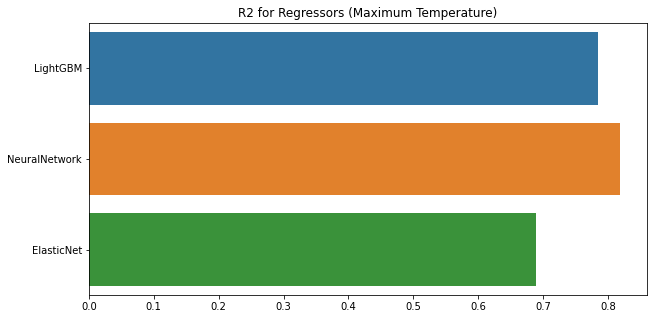

In [53]:
plt.figure(figsize=(10, 5))
model_accuracies = list(r2_values.values())
model_names = list(r2_values.keys())
sns.barplot(x=model_accuracies, y=model_names)
plt.title('R2 for Regressors (Maximum Temperature)')

### RMSE (Root Mean Squared Error)

Essa métrica é utilizada para identificar o erro em modelos de regressão e é sensível a *outliers*, conseguindo considerar melhor o desempenho dos modelos quanto a grandes erros. Sua medida é dada de acordo com a unidade do atributo alvo. Quanto menor o valor dessa métrica, melhor é o desempenho do modelo.

Text(0.5, 1.0, 'RMSE for Regressors (Maximum Temperature)')

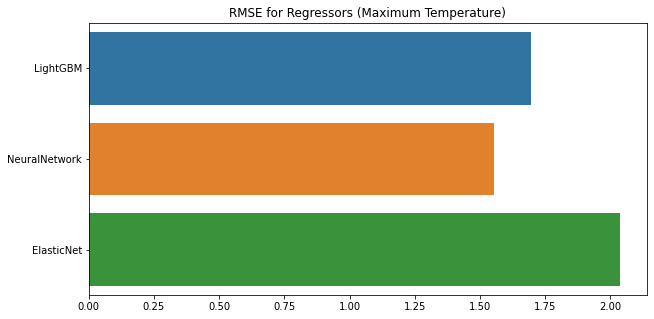

In [51]:
plt.figure(figsize=(10, 5))
model_accuracies = list(RMSE_values.values())
model_names = list(RMSE_values.keys())
sns.barplot(x=model_accuracies, y=model_names)
plt.title('RMSE for Regressors (Maximum Temperature)')

### MAE (Mean Absolute Error)

Essa métrica é também é utilizada para identificar o erro em modelos de regressão e já não é tão sensível a grandes erros. Essa métrica foi escolhida como forma de comparação à métrica RMSE. Uma diferença grande entra essas duas pode significar uma alta presença de *outliers* na previsão.

Text(0.5, 1.0, 'MAE for Regressors (Maximum Temperature)')

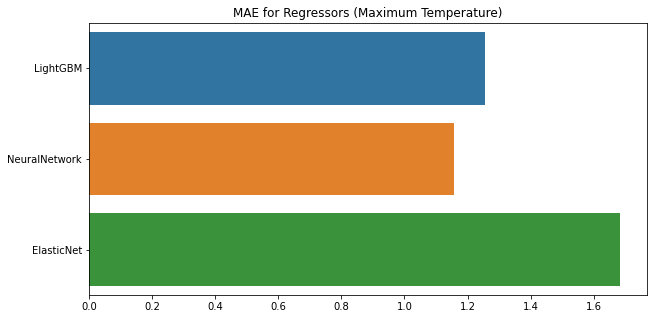

In [54]:
plt.figure(figsize=(10, 5))
model_accuracies = list(MAE_values.values())
model_names = list(MAE_values.keys())
sns.barplot(x=model_accuracies, y=model_names)
plt.title('MAE for Regressors (Maximum Temperature)')

## Next steps

Como próximos passos, existem alguns pontos que precisam ser explorados, estes são:

1. **Um investimento maior de tempo na feature engineering**: Considerar uma janela de tempo de n dias e gerar novas features baseadas nas já existentes. Por exemplo: considerando uma janela de 3 dias, calcular a média e desvio padrão da temperatura máxima dos últimos 3 dias e adicionar como uma nova feature ao conjunto de dados. Explorar essa possibilidade dada pelas séries temporais pode aumentar bastante o desempenho dos modelos gerados.


2. **Treinar mais estimadores de algoritmos diferentes**: Considerar outros algoritmos como Random Forest e XGBoost, por exemplo. Uma busca em grid por hiperparâmetros desses estimadores pode ajudar a encontrar resultados melhores do que os encontrados durante este experimento. Um outro ponto também seria testar o treinamento também de Redes Neurais Recorrentes como a LSTM, pois sabe-se que este tipo de arquitetura apresenta bons resultados para problemas envolvendo séries temporais.


3. **Uma busca maior de hiperparâmetros nas Redes Neurais**: Como se sabe, as redes neurais tem um tempo alto de treinamento. Portanto, considerando o tempo dado para a conclusão deste desafio, não houve uma busca satisfatória de hiperparâmetros através do GridSearch. Um próximo passo visando esta busca seria um ótimo investimento, considerando que obteve-se o melhor desempenho dentre os modelos aqui apresentado.